<a href="https://colab.research.google.com/github/1975JHK/1975JHK.github.io/blob/main/Prediction_Model_with_Oversampling_over_minority_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installing the required packages
pcks <- c('tidyverse', 'readxl', 'caret', 'see',
            'e1071', 'DT', 'easypackages')
install.packages(pcks)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘lazyeval’, ‘later’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’, ‘bayestestR’, ‘datawizard’, ‘effectsize’, ‘ggridges’, ‘insight’, ‘parameters’, ‘proxy’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’




In [ ]:
##################################################
# Performance Comparison among predictive models #
#  1) Default Parameters                         #
#  2) Hyper-Parameters Optimization              #
#  3) SVM Bagging                                #
#  4) SVM Bagging + Baseline OOD Detection       #
# Coded on August 9, 2020                        #
# Coded By Robin Kim                             #
##################################################
  
# Loading the required Package
library(easypackages)
libraries(c('tidyverse', 'readxl', 'caret', 'see',
            'e1071', 'DT'))

# Setting up the environments
Sys.setenv(LANG = 'en')
theme_set(new = theme_minimal())
options(warn=-1)

# Importing the dataset
raw <- read_excel('/content/process_data.xlsx')
str(raw)


# Initial Preprocessing ---------------------------------------------------
## Extracting 2nd Plat Data from Raw Dataset
raw <- raw %>% filter(Var1 == 'P2')

## Feature Selection
df <- raw[ , -c(1:6, 10, 14:15, 38:45, 51:61, 63:64)]
colnames(df)

## Handling the Not Availables
apply(df, 2, function(x) sum(is.na(x)))
df <- na.omit(df)

## Classifying Tissu.Type
df$Var49 <- ifelse(df$Var49 == 'J' & df$Var52 < 3000, 'S', df$Var49)
df <- df[ , -35]

## Removing features with zero variance 
nearZeroVar(df, saveMetrics = T)
df.nvz <- nearZeroVar(df, saveMetrics = F)
df <- df[ , -df.nvz]

df <- df[ , -16]  # consists with zero(0)

## Separating the dates
df <- df %>% separate(Var8, into = c('Year', 'Month', 'Day'), sep = '/')
df <- df %>% filter(!c(Year == '20' & Month %in% c('01', '02', '12')))
addmargins(table(df$Month))

## Encoding on Tissu.Type
df$Var49 <- factor(df$Var49)

## CTQ 정리
df <- df[ , -c(30:32)] # Not the Target

## Target
df$Y3 <- apply(df[ , 28:29], 1, mean)
df <- df[ , -c(28:29)]


## Removing outliers
### CTQs
df <- df %>% filter(Y3 > -2.0, Y3 < -0.1)

### React.Time
df <- df %>% filter(Var11 > 10, Var11 < 50)

### React.Temp
df <- df %>% filter(Var12 > 50, Var12 < 150)

### Line Speed
df <- df %>% filter(Var24 > 3.0)

### Upper and Lower Dryer Temp
df <- df %>% filter(Var25 > 45 & Var25 < 70)
df <- df %>% filter(Var26 > 45 & Var26 < 70)

### Pressure2
df <- df %>% filter(Var28 >= 0 & Var28 < 10)

### Pressure3
df <- df %>% filter(Var29 >= 0 & Var29 < 10)

### Pressure4
df <- df %>% filter(Var30 >= 0 & Var30 < 30)

### Pressure5
df <- df %>% filter(Var31 > 0)

### Pressure6
df <- df %>% filter(Var32 > 5)

### Pressure7
df <- df %>% filter(Var33 > 10)

### Pressure8
df <- df %>% filter(Var34 > 20)

### Pressure9
df <- df %>% filter(Var35 > 10)

### Pressure10
df <- df %>% filter(Var36 > 10)

### Pressure11
df <- df %>% filter(Var37 > 5 & Var37 < 40)

### Blower
df <- df %>% filter(Var18 < 12)

### Viscosity
df <- df %>% filter(Var9 >= 20000 & Var9 <= 50000)


# Feature Engineering -----------------------------------------------------
## Pressure slope on Dryers
df <- df %>% mutate(P1 = Var32 - Var30,
                    P2 = Var34 - Var32,
                    P3 = Var34 - Var37)

## Arranging dataset
colnames(df)
df <- df[ , c(1:28, 30:32, 29)]
colnames(df)



# Secondary Preprocessing -------------------------------------------------
## Encoding : Y3(Target)
df$Y3 <- case_when(df$Y3 < -1.00 ~ 'Bad',
                   df$Y3 < 0.00 ~ 'Good',
                   TRUE ~ 'NA')

df$Y3 <- factor(df$Y3,
                levels = c('Good', 'Bad'),
                labels = c('Good', 'Bad'))

## Encoding : Var49
addmargins(table(df$Var49))
df$Var49 <- as.numeric(df$Var49)
addmargins(table(df$Var49))
table(is.na(df))
df <- na.omit(df)

## Feature Selection
df <- df[ , -c(1:4, 13:14)]
colnames(df)


## Splitting the dataset into train and test set
set.seed(1975)
index <- sample(1:nrow(df), nrow(df)*0.70, replace = F)
train <- df[index, ]
test <- df[-index, ]

## Rebalancing the extremely imbalanced dataset
## Oversampling over minority classes
minor_bad <- train %>% filter(Y3 == 'Bad')
minor_bad <- as.data.frame(lapply(minor_bad, rep, 15))
train <- rbind(train, minor_bad)


## Scaling Features
center = apply(train[ , 1:25], 2, mean)
scale = apply(train[ , 1:25], 2, sd)
train[ , -26] <- scale(train[ , -26], center = center, scale = scale)
test[ , -26] <- scale(test[ , -26], center = center, scale = scale)
head(train, 3)
head(test, 3)
dim(train)
dim(test)

# Importing the new testset generated by SMOTE
## Testset to evaluate the performance for the model with Conventional oversampling
test <- read.csv('/content/test.csv')[-1]
test$Y3 <- factor(test$Y3, levels = c('Good', 'Bad'), labels = c('Good', 'Bad'))
str(test)

Confusion Matrix and Statistics

          Reference
Prediction Good Bad
      Good   88  42
      Bad     1  22
                                          
               Accuracy : 0.719           
                 95% CI : (0.6407, 0.7886)
    No Information Rate : 0.5817          
    P-Value [Acc > NIR] : 0.0003028       
                                          
                  Kappa : 0.3654          
                                          
 Mcnemar's Test P-Value : 1.061e-09       
                                          
            Sensitivity : 0.9888          
            Specificity : 0.3438          
         Pos Pred Value : 0.6769          
         Neg Pred Value : 0.9565          
             Prevalence : 0.5817          
         Detection Rate : 0.5752          
   Detection Prevalence : 0.8497          
      Balanced Accuracy : 0.6663          
                                          
       'Positive' Class : Good            
                           

,kernel,cost,gamma,epsilon,kappa,accuracy,score
,<fct>,<dbl>,<dbl>,<dbl>,<I<chr>>,<I<chr>>,<I<chr>>
1,radial,1,0.01,0.01,0.61,0.82,0.50


Confusion Matrix and Statistics

          Reference
Prediction Good Bad
      Good   84  23
      Bad     5  41
                                          
               Accuracy : 0.817           
                 95% CI : (0.7465, 0.8748)
    No Information Rate : 0.5817          
    P-Value [Acc > NIR] : 4.892e-10       
                                          
                  Kappa : 0.6085          
                                          
 Mcnemar's Test P-Value : 0.001315        
                                          
            Sensitivity : 0.9438          
            Specificity : 0.6406          
         Pos Pred Value : 0.7850          
         Neg Pred Value : 0.8913          
             Prevalence : 0.5817          
         Detection Rate : 0.5490          
   Detection Prevalence : 0.6993          
      Balanced Accuracy : 0.7922          
                                          
       'Positive' Class : Good            
                           

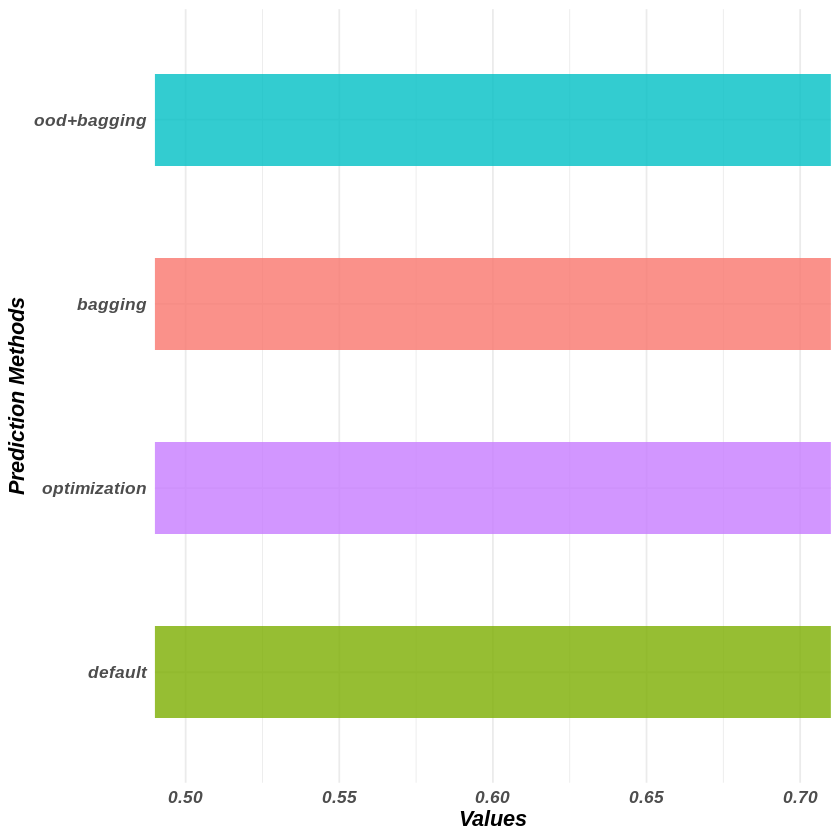

In [38]:
# Performance Comparison --------------------------------------------------
## 1. Default Parameters ---------------------------------------------------
default_model = svm(Y3 ~ ., data = train[ , c(1:26)],
                    type = 'C-classification')

default_pred <- predict(default_model, newdata = test[ , 1:25])

default_result <- data.frame(default_pred, test$Y3) %>% 
  rename(Predicted = default_pred, Actual = test.Y3)

cm1 <- with(default_result, confusionMatrix(Predicted, Actual))
print(cm1)
conclusion1 <- rep(NA, times = 3)
  conclusion1[1] = cm1$table[4]/(cm1$table[3] + cm1$table[4])
  conclusion1[2] = cm1$table[1]/(cm1$table[1] + cm1$table[2])
  conclusion1[3] = (cm1$table[1] + cm1$table[4])/
    (cm1$table[1] + cm1$table[2] + cm1$table[3] + cm1$table[4])

  
## 2. Hyper-Parameters Optimization ----------------------------------------
### 2-1. Optimization
type = 'C-classification'
kernel = c('radial', 'polynomial')
cost = seq(1, 10, by = 1)
gamma = seq(0.01, 0.1, by = 0.01)
epsilon = seq(0.01, 0.1, by = 0.01)
doe = expand.grid(kernel, cost, gamma, epsilon) %>% rename('kernel' = Var1, 
                                                           'cost' = Var2,
                                                           'gamma' = Var3,
                                                           'epsilon' = Var4)
kappa <- rep(NA, times = 2000)
accuracy <- rep(NA, times = 2000)
table <- cbind(doe, kappa, accuracy)

for(i in 1:2000){
  model2 = svm(Y3 ~ ., data = train[ , c(1:26)],
               type = type,
               kernel = table[i, 1],
               cost = table[i, 2],
               gamma = table[i, 3],
               epsilon = table[i, 4])
  
  y_pred2 = predict(model2, newdata = test[ , c(1:25)])
  cm2 = confusionMatrix(test$Y3, y_pred2)
  table[i, 5] <- cm2$overall[2]
  table[i, 6] <- cm2$overall[1]
}

table <- table %>% mutate(score = kappa * accuracy)
table[ ,c(5:7)] <- format(round(table[ , c(5:7)], 2) , nsmall = 2)
best2 <- table[which.max(table$score), ]
cat('\n Best Hyper-Parameters \n')
best2

### 2-2. Evaluation
opt_model2 = svm(Y3 ~ ., data = train[ , c(1:26)],
                 type = type,
                 kernel = best2[1, 1],
                 cost = best2[1, 2],
                 gamma = best2[1, 3],
                 epsilon = best2[1, 4])

opt_pred2 = predict(opt_model2, newdata = test[ , c(1:25)])
cm2 <- confusionMatrix(opt_pred2, test$Y3)
print(cm2)

conclusion2 <- rep(NA, times = 3)
conclusion2[1] = cm2$table[4]/(cm2$table[3] + cm2$table[4])
conclusion2[2] = cm2$table[1]/(cm2$table[1] + cm2$table[2])
conclusion2[3] = (cm2$table[1] + cm2$table[4])/
  (cm2$table[1] + cm2$table[2] + cm2$table[3] + cm2$table[4])



## 3. SVM with Bagging -----------------------------------------------------
new.result <- data.frame(trail.1 = rep(NA, times = nrow(test)))
for(i in 1:101){
  trial <- c(rep(NA, times = nrow(test)))
  new.result <- data.frame(new.result, trial)}

new.result2 <- cbind(
  new.result[ , -c(1:2)],
  majority = rep(NA, times = nrow(test)),
  count = rep(NA, times = nrow(test)),
  rate = rep(NA, times = nrow(test))
)

for(i in 1:100){
  index <- sample(1:nrow(train), nrow(train)*0.8, replace = F)
  new.train <- train[index, ]
  new.svm <- svm(Y3 ~ ., data = new.train[ , c(1:26)],
                 type = type,
                 kernel = best2[1, 1],
                 cost = best2[1, 2],
                 gamma = best2[1, 3],
                 epsilon = best2[1, 4])
  new.pred = predict(new.svm, newdata = test[ , c(1:25)])
  new.result2[ , i] <- new.pred
}

new.result2$majority <- apply(new.result2[ , 1:100], 1, function(x) names(which.max(table(x))))
new.result2$count <- apply(new.result2[ , 1:100], 1, function(x) max(table(x)))
new.result2$rate <- new.result2$count/100

finals2 <- data.frame(new.result2[ , c(101:103)], test$Y3)

cm3 = confusionMatrix(as.factor(finals2$majority), finals2$test.Y3)
print(cm3)

conclusion3 <- rep(NA, times = 3)
conclusion3[1] = cm3$table[4]/(cm3$table[3] + cm3$table[4])
conclusion3[2] = cm3$table[1]/(cm3$table[1] + cm3$table[2])
conclusion3[3] = (cm3$table[1] + cm3$table[4])/
  (cm3$table[1] + cm3$table[2] + cm3$table[3] + cm3$table[4])



## 4. OOD Detection --------------------------------------------------------
new.result <- data.frame(trail.1 = rep(NA, times = nrow(test)))
for(i in 1:101){
  trial <- c(rep(NA, times = nrow(test)))
  new.result <- data.frame(new.result, trial)}

new.result2 <- cbind(
  new.result[ , -c(1:2)],
  majority = rep(NA, times = nrow(test)),
  count = rep(NA, times = nrow(test)),
  rate = rep(NA, times = nrow(test))
)


for(i in 1:100){
  index <- sample(1:nrow(train), nrow(train)*0.8, replace = F)
  new.train <- train[index, ]
  new.svm <- svm(Y3 ~ ., data = new.train[ , c(1:26)],
                 type = type,
                 kernel = best2[1, 1],
                 cost = best2[1, 2],
                 gamma = best2[1, 3],
                 epsilon = best2[1, 4])
  new.pred = predict(new.svm, newdata = test[ , c(1:25)])
  new.result2[ , i] <- new.pred
}

new.result2$majority <- apply(new.result2[ , 1:100], 1, function(x) names(which.max(table(x))))
new.result2$count <- apply(new.result2[ , 1:100], 1, function(x) max(table(x)))
new.result2$rate <- new.result2$count/100

finals_sh <- data.frame(new.result2[ , c(101:103)], test$Y3)
test_kit2 <- data.frame(rate = seq(0.800, 0.999, by = 0.001),
                        accuraty = rep(NA, length = 200))
for(i in 1:nrow(test_kit2)){
  finals_sh2 <- finals_sh %>% filter(test_kit2[i, 1] < rate)
  cm = confusionMatrix(as.factor(finals_sh2$majority), 
                       finals_sh2$test.Y3)
  test_kit2[i, 2] = cm$overall[1]
}

best_rate2 <- test_kit2[which.max(test_kit2[ , 2]), 1]
finals_sh <- finals_sh %>% filter(best_rate2[1] <= rate)

cm4 = confusionMatrix(as.factor(finals_sh$majority), finals_sh$test.Y3)
print(cm4)

conclusion4 <- rep(NA, times = 3)
conclusion4[1] = cm4$table[4]/(cm4$table[3] + cm4$table[4])
conclusion4[2] = cm4$table[1]/(cm4$table[1] + cm4$table[2])
conclusion4[3] = (cm4$table[1] + cm4$table[4])/
  (cm4$table[1] + cm4$table[2] + cm4$table[3] + cm4$table[4])


# Conclusion --------------------------------------------------------------
final_report <- data.frame(
  conclusion1, conclusion2, conclusion3, conclusion4)
colnames(final_report) <- c('default', 'optimization',
                            'bagging', 'ood+bagging')
rownames(final_report) <- c('recall', 'precision', 'accuracy')
final_report <- t(final_report) %>% data.frame()
final_report <- rownames_to_column(final_report) %>% rename(methods = rowname)

ggplot(data = final_report, aes(x = methods %>% reorder(accuracy),
                                y = accuracy, fill = methods))+
  geom_col(size = 0.3, alpha = 0.8, show.legend = F, width = 0.5)+
  geom_text(aes(label = round(accuracy, 3)), size = 3.5, color = 'black',
            fontface = 'bold.italic')+
  coord_flip(ylim = c(0.50, 0.70))+
  labs(x = 'Prediction Methods', y = 'Values')+
  theme(text = element_text(size = 13, face = 'bold.italic'))